# rAdvisor graphs

## Notebook inputs

In [3]:
import os

# Name of the directory in `../data`
EXPERIMENT_DIRNAME = "BuzzBlogBenchmark_2021-10-10-18-35-22"
# Name of the directory in `../data/{experiment_dirname}/logs`
NODE_NAME = "pc715.emulab.net"
# Docker container ID to parse statistics for
# This can be the short (12 chars) or long (64 chars) ID;
# it is used as a prefix when matching against the log files.
CONTAINER_ID = "5e43e14129c7"

# This should be one of:
# - "blkio.service.bytes"
# - "blkio.throttle.service.bytes"
# - "blkio.bfq.service.bytes"
# Which key has actual data depends on the configuration of the system.
# More info:
# https://github.com/elba-docker/radvisor/blob/develop/docs/collecting.md#additional-blkio-entries
# https://www.kernel.org/doc/html/latest/admin-guide/cgroup-v1/blkio-controller.html
# https://access.redhat.com/documentation/en-us/red_hat_enterprise_linux/6/html/resource_management_guide/ch-subsystems_and_tunable_parameters#sec-blkio
IO_SERIES_KEY = "blkio.throttle.service.bytes"

# Collection interval, displayed on graphs
INTERVAL = "50ms"

## Setup

In [4]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lib.radvisor_parser as radvisor_parser
import math
import tarfile
import io
from typing import List, Iterable, Tuple, Dict, Any, Literal

In [5]:
def diff_percpu_value(a: List[int], b: List[int]) -> List[int]:
    return [max(a - b, 0) for (a, b) in zip(a, b)]

def diff_percpu(r):
    """Adapted from https://stackoverflow.com/questions/53808042/pandas-diff-but-user-defined-function"""
    return [np.NaN] + [diff_percpu_value(r[n + 1], r[n]) for n in range(r.shape[0] - 1)]

def construct_dataframe(log_file: Iterable[str]) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    """
    Constructs a dataframe containing all of the parsed rAdvisor log data,
    including a couple of additional columns with derived data that are used for analysis.
    Additionally, returns the YAML metadata included at the top of the log file.
    """

    log_iter, metadata = radvisor_parser.parse_target_log(log_file)
    dataframe = pd.DataFrame(log_iter)

    # Construct other series as needed for analysis
    min_timestamp = dataframe["read"].min()
    # Normalize timestamps by subtracting minimum
    dataframe["time"] = dataframe.apply(lambda r: (r["read"] - min_timestamp), axis=1)
    dataframe["time_diff"] = dataframe["time"].diff()
    dataframe["percpu_diff"] = diff_percpu(dataframe["cpu_usage_percpu"])
    # All log entry keys have their "."'s converted to "_";'s when imported
    io_series_key_corrected = IO_SERIES_KEY.replace('.', '_')
    dataframe["read"] = dataframe[io_series_key_corrected].apply(lambda i: i['read'])
    dataframe["write"] = dataframe[io_series_key_corrected].apply(lambda i: i['write'])
    dataframe["read_diff"] = dataframe["read"].diff().apply(lambda v: max(v, 0))
    dataframe["write_diff"] = dataframe["write"].diff().apply(lambda v: max(v, 0))

    return (dataframe, metadata)

In [6]:
tarball_path = os.path.join(os.pardir, "data", EXPERIMENT_DIRNAME, "logs", NODE_NAME, "radvisor.tar.gz")
with tarfile.open(tarball_path, "r:gz") as tar:
    container_log_filepath= None
    for filepath in tar.getnames():
        base_filename = os.path.basename(filepath)
        if base_filename.startswith(CONTAINER_ID) and base_filename.endswith(".log"):
            container_log_filepath = filepath
            break
    
    if not container_log_filepath:
        raise Exception(f"Could not find container log file with prefix {CONTAINER_ID}"
                        f" in tarball at {tarball_path}; all files in archive: {tar.getnames()}")

    with tar.extractfile(container_log_filepath) as log_file_byte_reader:
        # rAdvisor, written in Rust, always uses and outputs UTF-8 text
        log_file_string_reader = io.TextIOWrapper(log_file_byte_reader, encoding="utf-8")
        dataframe, metadata = construct_dataframe(log_file_string_reader)
        print(f"Generated dataframe for '{metadata['Metadata']['Names'][0]}' ({metadata['Metadata']['Id']})")

Generated dataframe for '/uniquepair_database' (5e43e14129c716951266c933dd96e9a0bd85f5d48118f7230ea0502ce8785414)


## Point-in-time / line graphs

- CPU (per-cpu rolled up into single time-series) - `cpu.usage.percpu`
- Memory - `memory.usage.current`
- I/O (read, write) - `blkio.service.bytes.read`, `blkio.service.bytes.write`

### CPU Point-in-time / line graph

In [7]:
# Graph inputs

# Size of the window to aggregate collection samples in.
WINDOW_SIZE_MS = 1_000

# Aggregation function used for windows.
WINDOW_AGGREGATION_FUNCTION = max

# The aggregation function used to aggregate
# each "CPU time consumed per-core" time-series for a single collection sample
# into a single "CPU time consumed" time-series.
# If using average, make sure to filter unused CPU cores;
# otherwise the average might be artificially depressed
# by a handful of permenant zeroes
PER_CPU_AGGREGATION_FUNCTION = max

In [8]:
def generate_cpu_series(dataframe: pd.DataFrame) -> pd.Series:
    """
    Generates the CPU time-series by aggregating the data.
    This mutates the dataframe by adding additional columns.
    """
    window_size_ns = int(WINDOW_SIZE_MS * 1e6)
    dataframe["cpu_diff"] = dataframe["percpu_diff"].apply(
        lambda d: PER_CPU_AGGREGATION_FUNCTION(d) if type(d) is list and d else 0)
    dataframe["cpu"] = dataframe.apply(
        lambda r: (r["cpu_diff"] / r["time_diff"] if r["time_diff"] != 0 else 0), axis=1)
    dataframe["cpu_window"] = dataframe.apply(lambda r: r["time"] // window_size_ns, axis=1)
    cpu_series = dataframe.groupby(["cpu_window"])["cpu"].agg(WINDOW_AGGREGATION_FUNCTION)
    # Convert the series index from window indices to seconds
    cpu_series.index = cpu_series.index.map(lambda i: i * (WINDOW_SIZE_MS / float(1e3)))
    # Convert to core-percentage
    cpu_series = cpu_series.apply(lambda v: v * 100)

    return cpu_series

/tmp/ipykernel_9193/3461129306.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.75)


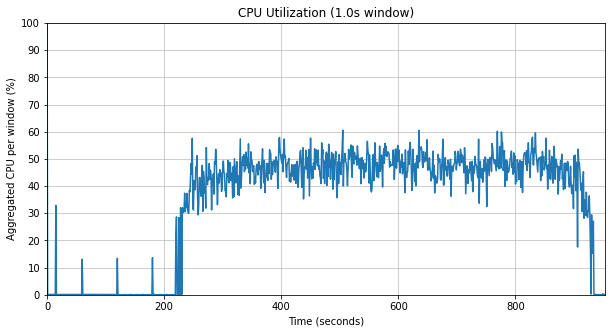

In [9]:
cpu_series = generate_cpu_series(dataframe)

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
max_time = cpu_series.index.max()
cpu_series.plot(ax=ax, kind="line", grid=True)
ax.set_xlim((0, max_time))
ax.set_ylim((0, 100))
ax.grid(b=True, alpha=0.75)
ax.set_title(f"CPU Utilization ({WINDOW_SIZE_MS / 1e3:.1f}s window)")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel(f"Aggregated CPU per window (%)")
ax.set_yticks(range(0, 101, 10))

None

### Memory Point-in-time / line graph

In [10]:
# Graph inputs

# Size of the window to aggregate collection samples in.
WINDOW_SIZE_MS = 1_000

# Aggregation function used for windows.
WINDOW_AGGREGATION_FUNCTION = np.mean

In [11]:
def generate_memory_series(dataframe: pd.DataFrame) -> pd.Series:
    """
    Generates the Memory time-series by aggregating the data.
    This mutates the dataframe by adding additional columns.
    """
    window_size_ns = int(WINDOW_SIZE_MS * 1e6)
    dataframe["memory_window"] = dataframe.apply(lambda r: r["time"] // window_size_ns, axis=1)
    memory_series = dataframe.groupby(["memory_window"])["memory_usage_current"].agg(WINDOW_AGGREGATION_FUNCTION)
    # Convert the series index from window indices to seconds
    memory_series.index = memory_series.index.map(lambda i: i * (WINDOW_SIZE_MS / float(1e3)))
    # Convert to MiB
    memory_series = memory_series.apply(lambda v: v / (1024 * 1024))

    return memory_series

/tmp/ipykernel_9193/391787504.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.75)


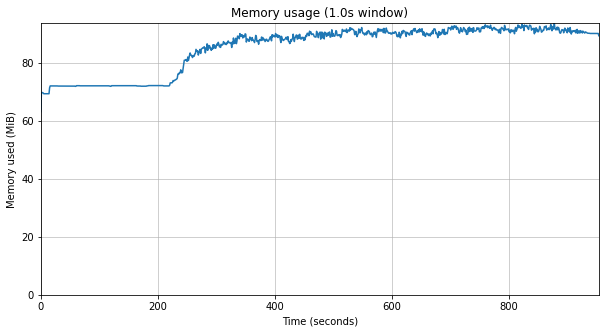

In [12]:
memory_series = generate_memory_series(dataframe)

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
max_time = memory_series.index.max()
max_memory = memory_series.max()
memory_series.plot(ax=ax, kind="line", grid=True)
ax.set_xlim((0, max_time))
ax.set_ylim((0, max_memory))
ax.grid(b=True, alpha=0.75)
ax.set_title(f"Memory usage ({WINDOW_SIZE_MS / 1e3:.1f}s window)")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel(f"Memory used (MiB)")

None

### I/O (Read, Write) Point-in-time / line graph

In [13]:
# Graph inputs

# Size of the window to aggregate collection samples in.
WINDOW_SIZE_MS = 1_000

# Aggregation function used for windows.
WINDOW_AGGREGATION_FUNCTION = sum

In [14]:
def generate_io_series(dataframe: pd.DataFrame, metric: Literal["read", "write"]) -> pd.Series:
    """
    Generates the IO time-series by aggregating the data.
    This mutates the dataframe by adding additional columns.
    """
    window_size_ns = int(WINDOW_SIZE_MS * 1e6)
    dataframe[f"io_{metric}_window"] = dataframe.apply(lambda r: r["time"] // window_size_ns, axis=1)
    io_series = dataframe.groupby([f"io_{metric}_window"])[f"{metric}_diff"].agg(WINDOW_AGGREGATION_FUNCTION)
    # Convert the series index from window indices to seconds
    io_series.index = io_series.index.map(lambda i: i * (WINDOW_SIZE_MS / float(1e3)))
    # Convert to KiB
    io_series = io_series.apply(lambda v: v / 1024)

    return io_series

/tmp/ipykernel_9193/3303785855.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.75)
/tmp/ipykernel_9193/3303785855.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.75)


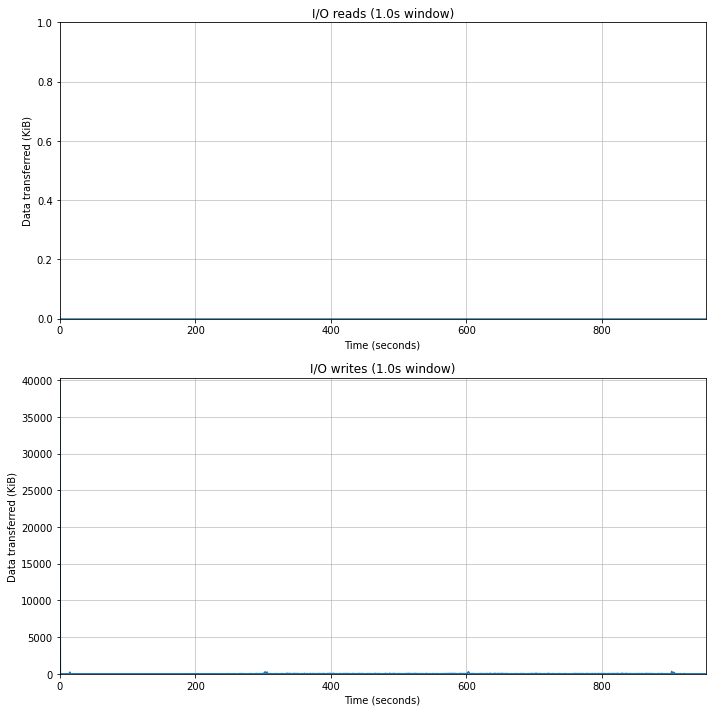

In [15]:
io_series = {
    "read": generate_io_series(dataframe, "read"),
    "write": generate_io_series(dataframe, "write"),
}

# Use the same max time for both plots
max_time = max(series.index.max() for series in io_series.values())

fig = plt.figure(figsize=(10, 10))
for (idx, (metric, series)) in enumerate(io_series.items()):
    ax = fig.add_subplot(2, 1, idx + 1)
    max_io = series.max()
    series.plot(ax=ax, kind="line", grid=True)
    ax.set_xlim((0, max_time))
    ax.set_ylim((0, max(max_io, 1)))
    ax.grid(b=True, alpha=0.75)
    ax.set_title(f"I/O {metric}s ({WINDOW_SIZE_MS / 1e3:.1f}s window)")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel(f"Data transferred (KiB)")
fig.tight_layout(h_pad=1.2)

None

## Histograms

- CPU (per-cpu rolled up into single time-series) - `cpu.usage.percpu`
- Memory - `memory.usage.current`
- I/O (read, write) - `blkio.service.bytes.read`, `blkio.service.bytes.write`

In [16]:
def generate_histogram_series(src_series: pd.Series, bin_width: float) -> pd.Series:
    """
    Generates a series containing the same number of points as src_series,
    where each value is the lower bin bound that the corresponding point belongs to.
    """
    bin_indices = (src_series
        .apply(lambda r: r // bin_width)
        .dropna()
        .apply(lambda r: int(r)))
    bin_lower_bounds = bin_indices.apply(lambda r: r * bin_width)
    return bin_lower_bounds

### CPU Histogram

In [17]:
# Graph inputs

# Size of the bins (in CPU-%) used to group data points.
CPU_UTIL_PERCENT_BIN_SIZE = 2

# The aggregation function used to aggregate
# each "CPU time consumed per-core" time-series for a single collection sample
# into a single "CPU time consumed" time-series.
# If using average, make sure to filter unused CPU cores;
# otherwise the average might be artificially depressed
# by a handful of permenant zeroes
PER_CPU_AGGREGATION_FUNCTION = max

In [18]:
def generate_cpu_histogram_series(dataframe: pd.DataFrame) -> pd.Series:
    """
    Generates the CPU histogram data by aggregating the data.
    This mutates the dataframe by adding additional columns.
    """
    dataframe["cpu_histogram_diff"] = dataframe["percpu_diff"].apply(
        lambda d: PER_CPU_AGGREGATION_FUNCTION(d) if type(d) is list and d else 0)
    cpu_series = dataframe.apply(
        lambda r: (r["cpu_histogram_diff"] / r["time_diff"] if r["time_diff"] != 0 else 0), axis=1)
    cpu_series = cpu_series.reindex(range(0, cpu_series.index.max() + 1))
    # Convert to core-percentage
    cpu_series = cpu_series.apply(lambda v: v * 100)
    return cpu_series

/tmp/ipykernel_9193/934219346.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.75, axis='y')


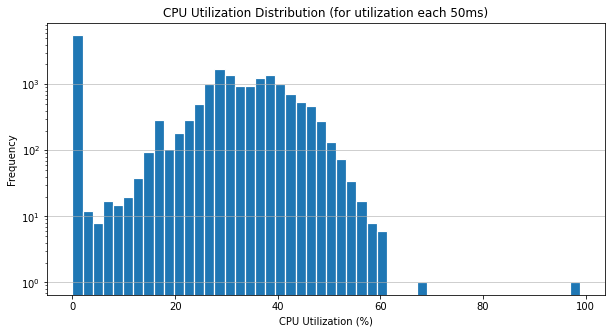

In [19]:
cpu_series = generate_cpu_histogram_series(dataframe)

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
cpu_series.plot(ax=ax, kind='hist', edgecolor='white', linewidth=1.2,
    bins=math.ceil((cpu_series.max() - cpu_series.min()) / CPU_UTIL_PERCENT_BIN_SIZE))
ax.grid(b=True, alpha=0.75, axis='y')
ax.set_yscale("log")
ax.set_title(f"CPU Utilization Distribution (for utilization each {INTERVAL})")
ax.set_xlabel("CPU Utilization (%)")
ax.set_ylabel("Frequency")

None

### Memory Histogram

In [20]:
# Graph inputs

# Size of the bins (in MiB) used to group data points.
MEMORY_MIB_BIN_SIZE = 1

In [21]:
def generate_memory_histogram_series(dataframe: pd.DataFrame) -> pd.Series:
    """
    Generates the Memory histogram data by aggregating the data.
    This mutates the dataframe by adding additional columns.
    """
    # Convert to MiB
    memory_series = dataframe["memory_usage_current"].apply(lambda v: v / (1024 * 1024))
    return memory_series

/tmp/ipykernel_9193/1304146738.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.75, axis='y')


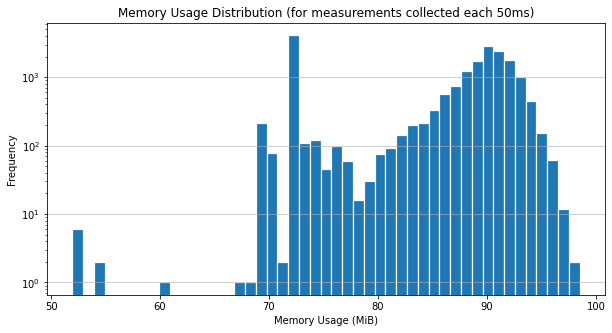

In [22]:
memory_series = generate_memory_histogram_series(dataframe)

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
memory_series.plot(ax=ax, kind='hist', edgecolor='white', linewidth=1.2,
    bins=math.ceil((memory_series.max() - memory_series.min()) / MEMORY_MIB_BIN_SIZE))
ax.grid(b=True, alpha=0.75, axis='y')
ax.set_yscale("log")
ax.set_title(f"Memory Usage Distribution (for measurements collected each {INTERVAL})")
ax.set_xlabel("Memory Usage (MiB)")
ax.set_ylabel("Frequency")

None

### I/O (Read, Write) Histograms

In [23]:
# Graph inputs

# Number of bins to use when plotting the IO data
IO_NUM_BINS = 20

In [24]:
def generate_io_histogram_series(dataframe: pd.DataFrame, metric: Literal["read", "write"]) -> pd.Series:
    """
    Generates the IO time-series by aggregating the data.
    This mutates the dataframe by adding additional columns.
    """
    # Convert to KiB
    io_series = dataframe[f"io_{metric}_window"].apply(lambda v: v / 1024)
    return io_series

/tmp/ipykernel_9193/213844025.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.75, axis='y')


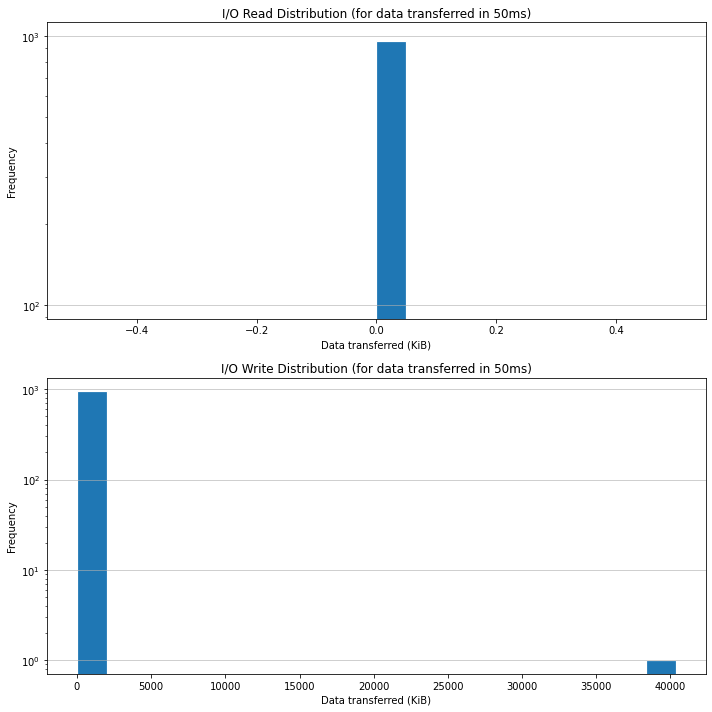

In [25]:
io_histogram_series = {
    "read": generate_io_histogram_series(dataframe, "read"),
    "write": generate_io_histogram_series(dataframe, "write"),
}

fig = plt.figure(figsize=(10, 10))
for (idx, (metric, series)) in enumerate(io_series.items()):
    ax = fig.add_subplot(2, 1, idx + 1)
    series.plot(ax=ax, kind='hist', edgecolor='white', linewidth=1.2, bins=IO_NUM_BINS)
    ax.grid(b=True, alpha=0.75, axis='y')
    ax.set_yscale("log")
    ax.set_title(f"I/O {metric.capitalize()} Distribution (for data transferred in {INTERVAL})")
    ax.set_xlabel("Data transferred (KiB)")
    ax.set_ylabel("Frequency")
fig.tight_layout(h_pad=1.2)

None